# Measuring the Universe with Supernovae

AST 3414 - Spring 2026

## Introduction

In this lab, you will use Type Ia supernova data to measure fundamental cosmological parameters:
- $H_0$: The Hubble constant (expansion rate of the universe today)
- $q_0$: The deceleration parameter (how fast the expansion is changing)
- $\Omega_m$: The matter density parameter
- $\Omega_\Lambda$: The dark energy density parameter

You'll use
2. Parameter estimation using χ² minimization
3. The difference between phenomenological and physical models

How to interpret uncertainties in fitted parameters

## Background

### Distance Modulus
The observed brightness of supernovae is related to their distance through the **distance modulus**:

$$\mu = m - M = 5\log_{10}\left(\frac{d_L}{10\,\text{pc}}\right)$$

where:
- $m$ is the apparent magnitude (how bright it appears)
- $M$ is the absolute magnitude (intrinsic brightness)
- $d_L$ is the luminosity distance in parsecs

### Luminosity Distance Models

**Model 1: Taylor expansion (phenomenological)**

For small redshifts, we can expand the luminosity distance:

$$d_L(z) = \frac{c}{H_0}\left[z + \frac{1}{2}(1-q_0)z^2 + \mathcal{O}(z^3)\right]$$

where $q_0 = \frac{1}{2}\Omega_m - \Omega_\Lambda$ is the deceleration parameter.

**Model 2: Friedmann equation (physical)**

The full solution from general relativity (for a flat universe):

$$d_L(z) = \frac{c(1+z)}{H_0}\int_0^z \frac{dz'}{\sqrt{\Omega_m(1+z')^3 + \Omega_\Lambda}}$$

where $\Omega_m + \Omega_\Lambda = 1$ for a flat universe.

---
**This is a Pair Programming Lab** - Please work together with all members looking at the same copy of the code on one computer. One member will be the **Driver** who controls the keyboard. The others will be the **Navigator(s)** who reviews code and think strategically, giving instructions to the Drive.

Every 20-30 minutes an announcement will be made to switch roles.

To get started, we need to import the libraries below.

In [ ]:
# Setup
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import quad
import pandas as pd

plt.rcParams['figure.figsize'] = (10, 6)
print("Ready!")

Ready!


# Load and Visualize Data

Make sure you have uploaded the file `Pantheon+SH0ES.dat` into the current working directory. If not, download it from https://github.com/PantheonPlusSH0ES/DataRelease

There is a lot of information in there, and we only want redshift (z) and distance modulus ($\mu$) and the associated errors. Note that the redshift is corrected for deviations from the "Hubble flow" due to local gravitational interactions.

In [ ]:
# Load supernova data
data = pd.read_csv('Pantheon+SH0ES.dat', delim_whitespace=True, comment='#')
z = data['zHD'].values
z_err = data['zHDERR'].values
mu = data['MU_SH0ES'].values
mu_err = data['MU_SH0ES_ERR_DIAG'].values
print(f"Loaded {len(z)} real supernovae!")

Loaded 1701 real supernovae!


/tmp/ipython-input-280261263.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv('Pantheon+SH0ES.dat', delim_whitespace=True, comment='#')


Plot the Hubble diagram (redshift vs. distance modulus) for all the supernovae.

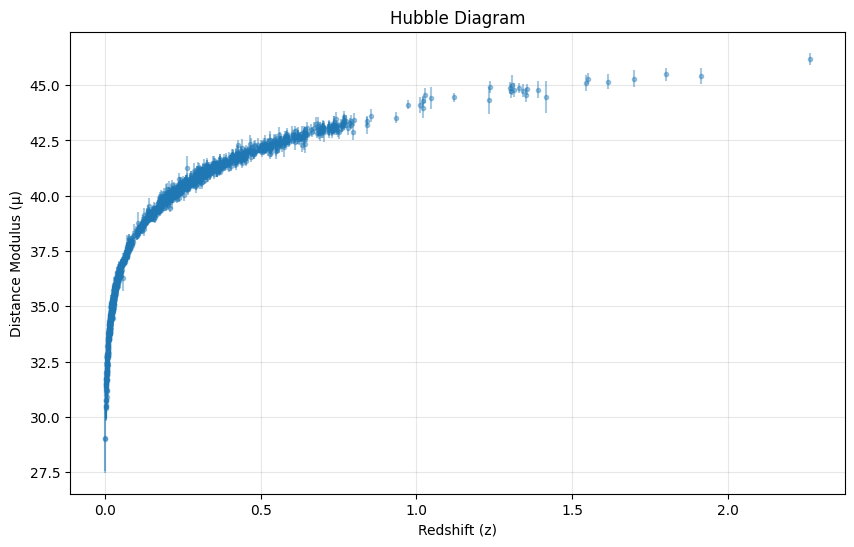

In [ ]:
plt.errorbar(z, mu, yerr=mu_err, fmt='o', alpha=0.4, ms=3)
plt.xlabel('Redshift (z)')
plt.ylabel('Distance Modulus (μ)')
plt.title('Hubble Diagram')
plt.grid(True, alpha=0.3)
plt.show()

## Question 1

That looks a bit different than the original Hubble plot (where's the straight line?) Why is this? Briefly discuss and modify the code to make a "linear" Hubble diagram like the orginal.

In [30]:
## CODE GOES HERE

Do we even need to fit a decelleration parameter? Let's guess a value for $H_0$ and generate a plot of the distance Modulus (μ) vs redshift (z) and a residual plot that subtracts off Hubble's law.

What do you notice about the residuals at high redshift?

In [ ]:
H0_guess = ### PUT IN YOUR GUESS HERE, units of km/s/Mpc

c = 299792.458  # km/s
d_L_empty = c * z / H0_guess  # Mpc
mu_empty = 5 * np.log10(d_L_empty) + 25

# making 2 graphs in one figure
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)

# Plot 1: Standard Hubble diagram
plt.errorbar(z, mu, yerr=mu_err, fmt='o', alpha=0.5, markersize=3,
             elinewidth=0.5, label='Supernova data')
plt.xlabel('Redshift (z)')
plt.ylabel('Distance Modulus (μ)')
plt.title('Hubble Diagram')
plt.grid(True, alpha=0.3)
plt.legend()

# Plot 2: Residuals from empty universe (for comparison)
plt.subplot(1, 2, 2) # telling python this is the second graph
plt.errorbar(z, mu - mu_empty, yerr=mu_err, fmt='o', alpha=0.5,
             markersize=3, elinewidth=0.5)
plt.axhline(0, color='red', linestyle='--', label='Empty universe')
plt.xlabel('Redshift (z)')
plt.ylabel('Δμ (relative to empty universe)')
plt.title('Hubble Diagram Residuals')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

## Linear Regression using χ²

Now we will define a model and use ```curve_fit``` from the scipy library to  minimize χ² and estimate errors on the fit parameters.

First, we define the χ² statistics for our model that the fit will minimize.

In [20]:
def chi_squared(obs, model, sigma):
    return np.sum(((obs - model) / sigma)**2)

def reduced_chi2(obs, model, sigma, n_params):
    return chi_squared(obs, model, sigma) / (len(obs) - n_params)

print("χ² functions ready!")

χ² functions ready!


Next, we define the function we would like to fit, the distance modulus as a function of z, defined by a taylor expansion of the luminosity distance to include our two numbers: $H_0$ and $q_0$.

Note that ```curve_fit``` will return two arrays: **popt, pcov**. popt contains the best-fit values of the parameters. The return value pcov contains the covariance (error) matrix for the fit parameters. From them we can determine the standard deviations of the parameters, just as we did for linear least chi square. (The standard deviations are the square roots of the diagonal values.) We can also determine the correlation between the fit parameters.

Not that in the print statement we use the fit parameters to plot a line of best fit: ```mu_taylor(zz, *popt)```. The star before *popt unpacks the popt array so the two optimized parameter values become the second and third arguments to the function.



TAYLOR FIT (z < 0.5)
H₀ = 72.01 ± 0.26 km/s/Mpc
q₀ = -0.116 ± 0.032
χ²_red = 0.452


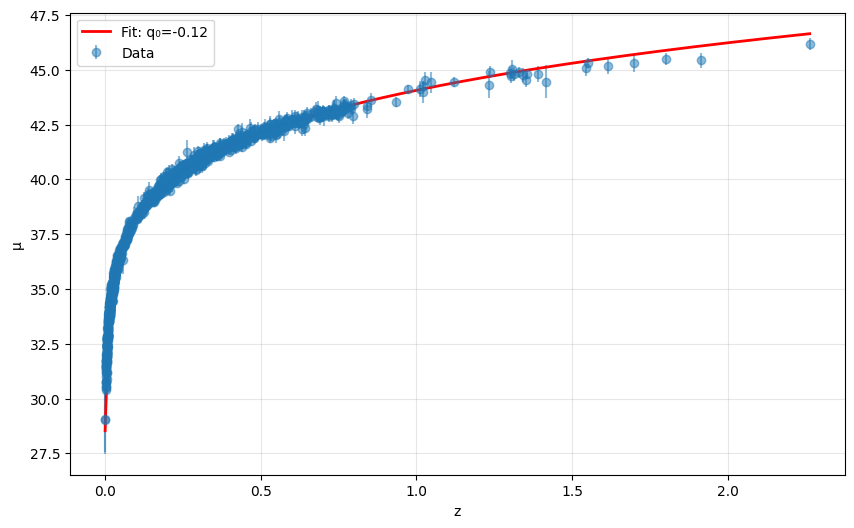

In [29]:
c = 299792.458  # km/s

def mu_taylor(z, H0, q0):
    d_L = (c / H0) * (z + 0.5 * (1 - q0) * z**2)
    return 5 * np.log10(d_L) + 25

popt, pcov = curve_fit(mu_taylor, z, mu,
                       sigma=mu_err, p0=[70, 0], absolute_sigma=True)

H0_t, q0_t = popt
H0_err, q0_err = np.sqrt(np.diag(pcov))

print(f"TAYLOR FIT (z < 0.5)")
print(f"H₀ = {H0_t:.2f} ± {H0_err:.2f} km/s/Mpc")
print(f"q₀ = {q0_t:.3f} ± {q0_err:.3f}")
print(f"χ²_red = {reduced_chi2(mu, mu_taylor(z, *popt), mu_err, 2):.3f}")

# Plot
plt.errorbar(z, mu, yerr=mu_err, fmt='o', alpha=0.5, label='Data')
zz = np.linspace(min(z), max(z), 200)
plt.plot(zz, mu_taylor(zz, *popt), 'r-', lw=2, label=f'Fit: q₀={q0_t:.2f}')
plt.xlabel('z'); plt.ylabel('μ'); plt.legend(); plt.grid(True, alpha=0.3)
plt.show()

## Question

Are we justified in using all redshift values to fit this Taylor series expansion? If not, determine an approximate maximum value of $z$ up to which our approximation should hold, and repeat the fit by restricting only those data points that lie below $z_max$. Does this change the fit parameters and errors?

In [ ]:
## CODE HERE

Let's visualize how χ² changes as we vary H₀ and q₀. This is called a "χ² map" or "likelihood contour."

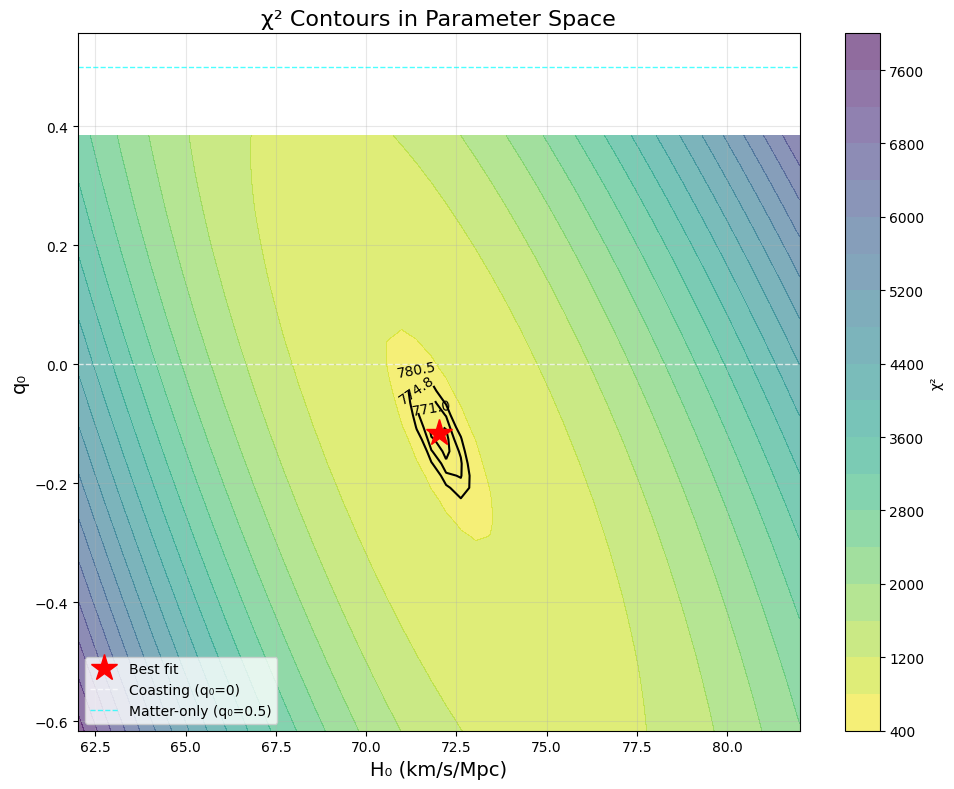


💡 Understanding confidence regions:
   - Δχ² = 2.3 → 68% confidence (1σ)
   - Δχ² = 6.17 → 95% confidence (2σ)
   - Δχ² = 11.8 → 99.7% confidence (3σ)

   The contours show how well we've constrained the parameters.
   Narrow contours = well constrained, wide contours = poorly constrained


In [37]:
# Calculate goodness of fit
mu_model_taylor = mu_taylor(z, H0_fit, q0_fit)
chi2_taylor = chi_squared(mu, mu_model_taylor, mu_err)
chi2_red_taylor = reduced_chi2(mu, mu_model_taylor, mu_err, n_params=2)

# Create a grid of H0 and q0 values
H0_fit = H0_t
q0_fit = q0_t

H0_range = np.linspace(H0_fit - 10, H0_fit + 10, 50)
q0_range = np.linspace(q0_fit - 0.5, q0_fit + 0.5, 50)
H0_grid, q0_grid = np.meshgrid(H0_range, q0_range)

# Calculate chi2 for each combination
chi2_grid = np.zeros_like(H0_grid)
for i in range(len(H0_range)):
    for j in range(len(q0_range)):
        mu_model = mu_taylor(z, H0_grid[j, i], q0_grid[j, i])
        chi2_grid[j, i] = chi_squared(mu, mu_model, mu_err)

# Plot chi-squared map
plt.figure(figsize=(10, 8))
levels = chi2_taylor + np.array([2.3, 6.17, 11.8])  # 1σ, 2σ, 3σ for 2 parameters
contours = plt.contour(H0_grid, q0_grid, chi2_grid, levels=levels, colors='black')
plt.clabel(contours, inline=True, fontsize=10, fmt='%.1f')

# Fill contours with color
plt.contourf(H0_grid, q0_grid, chi2_grid, levels=20, cmap='viridis_r', alpha=0.6)
plt.colorbar(label='χ²')

# Mark best fit
plt.plot(H0_fit, q0_fit, 'r*', markersize=20, label='Best fit')

# Mark special cosmologies
plt.axhline(0, color='white', linestyle='--', linewidth=1, alpha=0.7, label='Coasting (q₀=0)')
plt.axhline(0.5, color='cyan', linestyle='--', linewidth=1, alpha=0.7, label='Matter-only (q₀=0.5)')

plt.xlabel('H₀ (km/s/Mpc)', fontsize=14)
plt.ylabel('q₀', fontsize=14)
plt.title('χ² Contours in Parameter Space', fontsize=16)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n💡 Understanding confidence regions:")
print("   - Δχ² = 2.3 → 68% confidence (1σ)")
print("   - Δχ² = 6.17 → 95% confidence (2σ)")
print("   - Δχ² = 11.8 → 99.7% confidence (3σ)")
print("\n   The contours show how well we've constrained the parameters.")
print("   Narrow contours = well constrained, wide contours = poorly constrained")

## Question

Now let's use some physics! Instead of using a Taylor expansion, we can solve the Friedmann equation for the luminosity distance:

$d_L(z) = \frac{c(1+z)}{H_0}\int_0^z \frac{dz'}{\sqrt{\Omega_m(1+z')^3 + \Omega_\Lambda}}$

But now we have to integrate it! ```scipy``` has a nice numerical integrator called ```quad``` that we use to fit H₀ and Ωₘ (assuming the universe is flat, so that Ω_Λ = 1 - Ωₘ).

**Note:** This might be your first time seeing Python's ```lambda``` function. It's a function that has no name, can only contain one expression, and automatically returns the result of that expression. For example, we could write a function named "double" to double a function...

```
def double(n):
  return 2 * n
  ```

You can do the same thing without first defining a named function by using a lambda instead - it's creating a function right as you use it:

```
print((lambda n: 2 * n)(2))
```

You can verify that they both return the same thing.

**Note:** We are doing numerical integrals, so this may also take a minute to run.

Fitting Friedmann model to full dataset...
FRIEDMANN FIT (full dataset)
H₀ = 72.97 ± 0.26 km/s/Mpc
Ωₘ = 0.351 ± 0.019
Ω_Λ = 0.649
q₀ = -0.474 (derived)
χ²_red = 0.439


/tmp/ipython-input-1641693655.py:10: RuntimeWarning: divide by zero encountered in log10
  return 5 * np.log10(dL) + 25


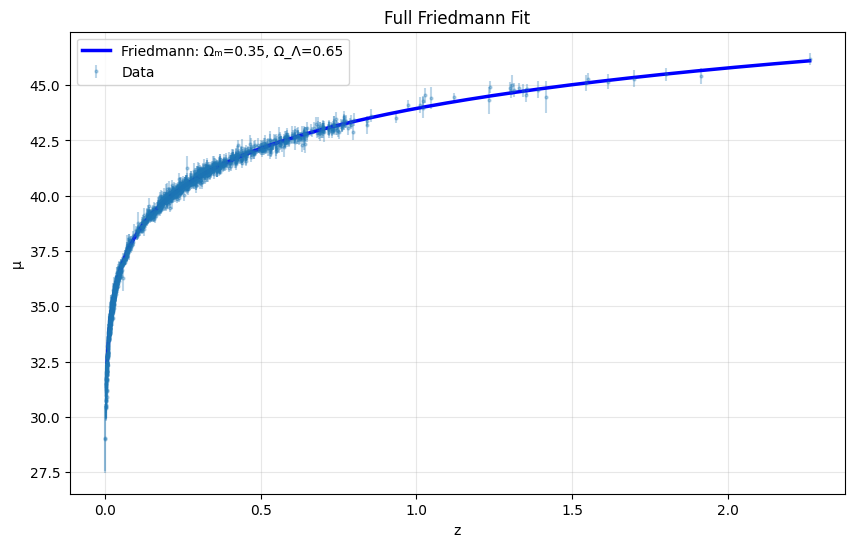

In [31]:
def E(z, Om):
    return np.sqrt(Om * (1+z)**3 + (1-Om))

def mu_friedmann(z, H0, Om):
    z_arr = np.atleast_1d(z)
    dL = []
    for zi in z_arr:
        integ, _ = quad(lambda zp: 1/E(zp, Om), 0, zi)
        dL.append(c * (1 + zi) * integ / H0)
    return 5 * np.log10(dL) + 25

# Fit (may take ~1 minute)
print("Fitting Friedmann model to full dataset...")
popt_f, pcov_f = curve_fit(mu_friedmann, z, mu, sigma=mu_err,
                           p0=[70, 0.3], absolute_sigma=True, maxfev=5000)

H0_f, Om_f = popt_f
H0_f_err, Om_f_err = np.sqrt(np.diag(pcov_f))
OL_f = 1 - Om_f
q0_f = 0.5*Om_f - OL_f

print(f"FRIEDMANN FIT (full dataset)")
print(f"H₀ = {H0_f:.2f} ± {H0_f_err:.2f} km/s/Mpc")
print(f"Ωₘ = {Om_f:.3f} ± {Om_f_err:.3f}")
print(f"Ω_Λ = {OL_f:.3f}")
print(f"q₀ = {q0_f:.3f} (derived)")
print(f"χ²_red = {reduced_chi2(mu, mu_friedmann(z, *popt_f), mu_err, 2):.3f}")

# Plot
plt.errorbar(z, mu, yerr=mu_err, fmt='o', alpha=0.3, ms=2, label='Data')
zz = np.linspace(0, max(z), 300)
plt.plot(zz, mu_friedmann(zz, *popt_f), 'b-', lw=2.5,
         label=f'Friedmann: Ωₘ={Om_f:.2f}, Ω_Λ={OL_f:.2f}')
plt.xlabel('z'); plt.ylabel('μ'); plt.legend(); plt.grid(True, alpha=0.3)
plt.title('Full Friedmann Fit')
plt.show()

## Question

Create a likelihood contour map for the fitted parameters $H_0$ and $\Omega_M$ for the Friedmann equation fits. How do the measured values compare to our Benchmark model paremeters?

## Question

Repeat the Friedmann model fit using only the cosmological constant $\Lambda$ (not matter). Then repeat this again with just matter, but no $\Lambda$. These fits represent alternative models. Create the Hubble plot with all three models plotted and justify which fits our universe best.


## Question

Compare your fitted values for $H_0$ from both the Taylor expansion and Friedmann equation methods. Which is more accurate? Do they predict measurably different ages for the universe?

## Question

We only used statistical uncertainties for our fits. What systematic effects might we be missing? (Discuss more than one.) If you took a previous astronomy course, how might dust extinction affect our results?

## Question

What constraints can be placed on the radiation density? Is it worth trying to edit the code to include this component of the universe? To what redshift would we need to detect supernovae to have a meaningful ability to constrain the radiation density in this way?

## Question

What constraints can be placed on the curvature of the universe with supernovae data? Edit the code to account for a non-zero curvature term (note that you will need to assume positive or negative curvature). How well are you able to measure the radius of curvature of our universe? Is it consistent with zero?